In [1]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.io import  gtfs_importer
from quetzal.model import stepmodel

import numpy as np
import pandas as pd
from quetzal.io import display

In [2]:
training_folder = '../../'

In [3]:
sm = stepmodel.read_zip(training_folder + 'model/transport/aon_pathfinder.zip')

read_hdf: : 100%|██████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 18.02it/s]


# impedances

# generation

Modèle très simple : 
- Emissions = Population
- Attractions = Emplois

In [4]:
sm.zones['emission'] =  sm.zones['pop'].astype(int) / 10 # peak hour generation
sm.zones['attraction'] =  sm.zones['emp'].astype(int) / 10
sm.zones['pop'].sum()

2158238.2271273527

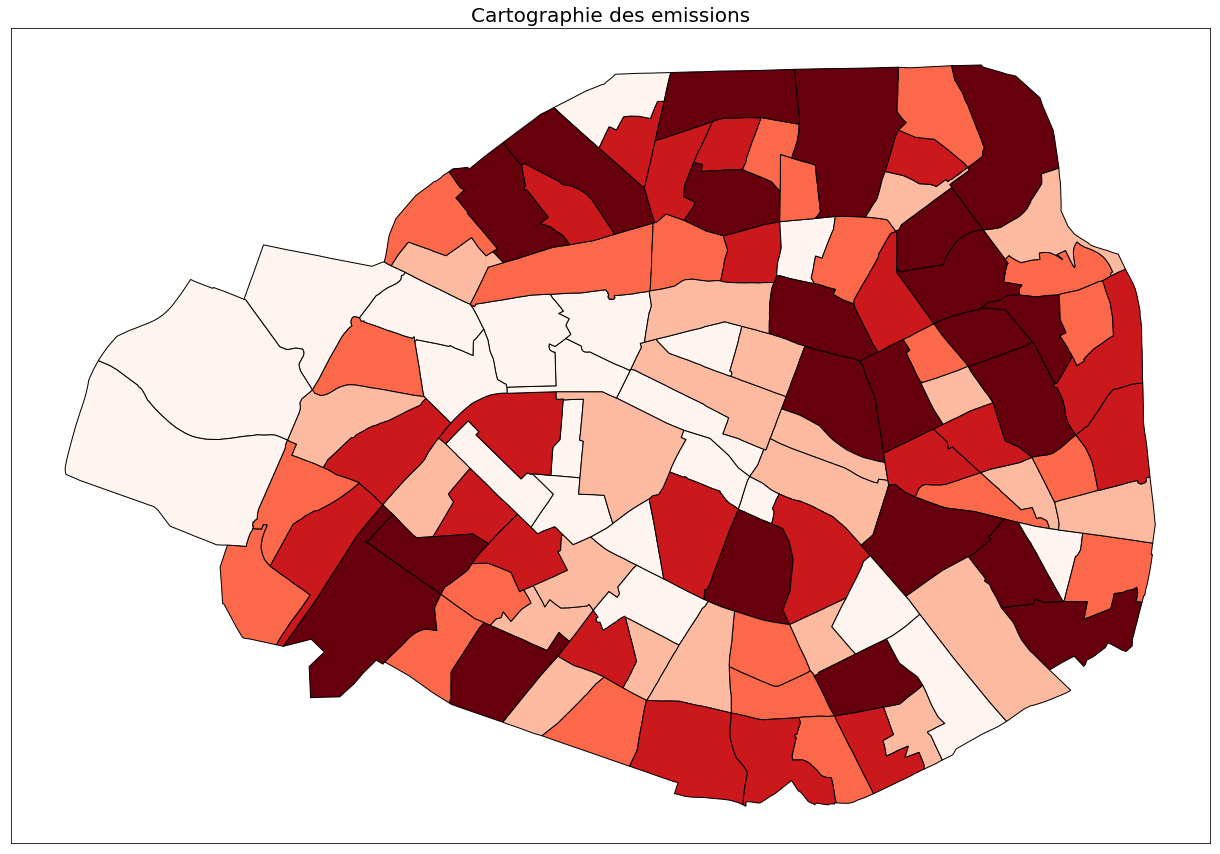

In [23]:
%matplotlib inline
plot = sm.plot('zones', column='emission', alpha=1, figsize=[25, 15], cmap='Reds', edgecolor='black' ,scheme='quantiles')
plot.set_xticks([])
plot.set_yticks([])
plot.set_title("Cartographie des emissions", fontsize=20)
fig = plot.get_figure()
fig.savefig('distribution_a.png')

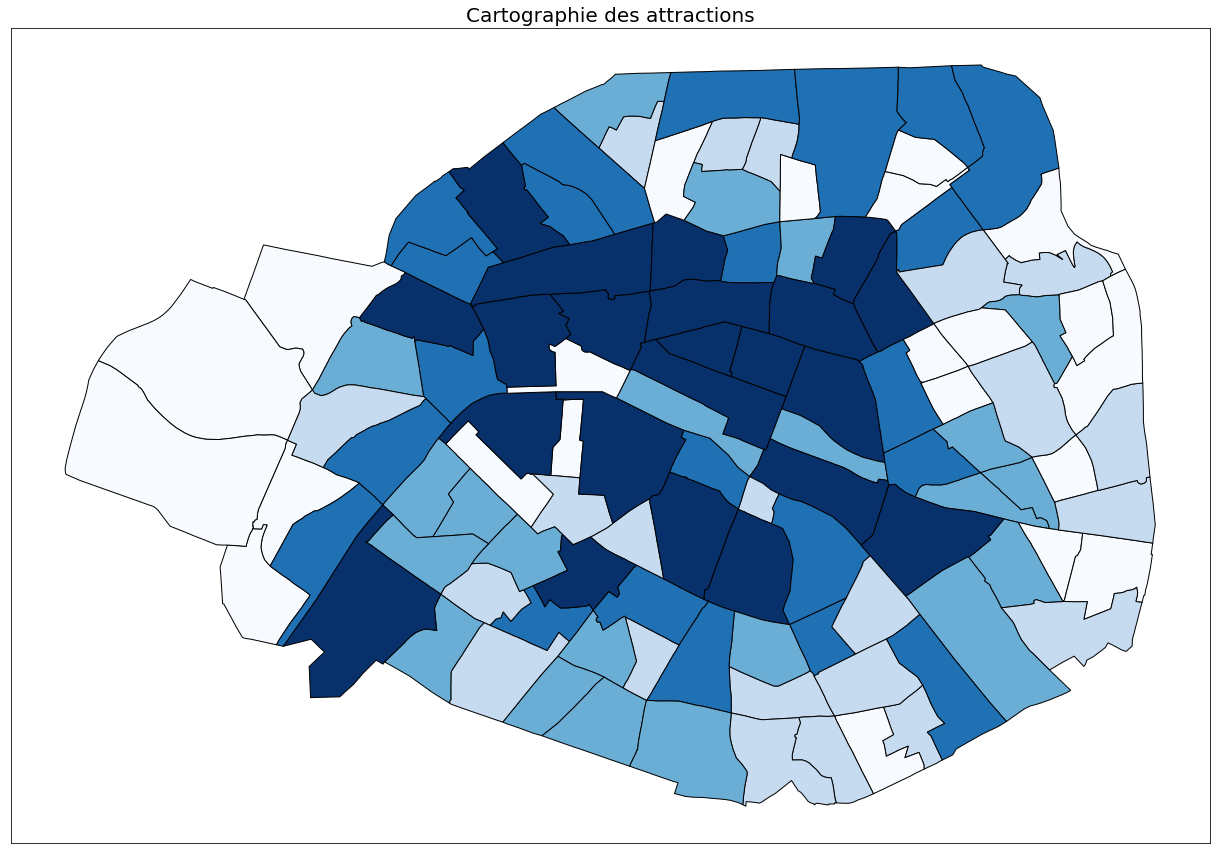

In [24]:
plot = sm.plot('zones', column='attraction', alpha=1, figsize=[25, 15], cmap='Blues', edgecolor='black', scheme='quantiles')
plot.set_xticks([])
plot.set_yticks([])
plot.set_title("Cartographie des attractions", fontsize=20)
fig = plot.get_figure()
fig.savefig('distribution_b.png')

In [6]:
motor_rate = 0.3

# car owners

In [7]:
car = sm.copy()
car.zones['emission'] *= motor_rate

In [8]:
imp_matrix = car.car_los[
    ['origin', 'destination', 'time']
].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)

car.step_distribution(impedance_matrix=imp_matrix)

Checking production, attraction balancing:
Production:  64745.49000000002
Attraction:  164266.19999999987
Productions and attractions do not balance, attractions will be scaled to productions!


# PT captives

In [9]:
pt = sm.copy()
pt.zones['emission'] *= (1-motor_rate)

In [10]:
# Ici on prend comme fonction de coût le temps TC. Notez le .unstack() 
imp_matrix = pt.pt_los[
    ['origin', 'destination', 'gtime']
].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)

In [11]:
pt.step_distribution(impedance_matrix=imp_matrix)

Checking production, attraction balancing:
Production:  151072.81
Attraction:  164266.19999999987
Productions and attractions do not balance, attractions will be scaled to productions!


In [12]:
sm.volumes = pd.merge(
    car.volumes,
    pt.volumes,
    on=['origin', 'destination'],
    suffixes=[ '_car_owner', '_pt_captive']
)

In [13]:
od = pd.merge(sm.volumes, sm.pt_los, on=['origin', 'destination'])
od = pd.merge(od, sm.car_los, on=['origin', 'destination'])

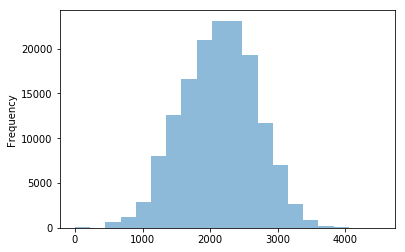

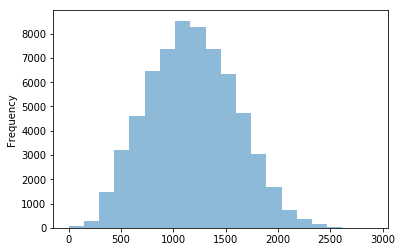

In [14]:
import matplotlib.pyplot as plt
od['gtime'].plot(kind='hist', weights=od['volume_pt_captive'], bins=20, alpha=0.5)
plt.show()
od['time'].plot(kind='hist', weights=od['volume_car_owner'], bins=20, alpha=0.5)

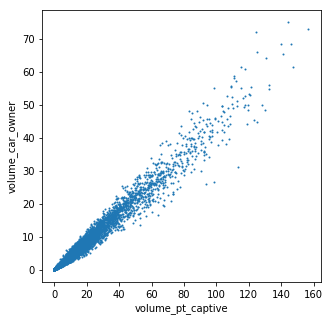

In [15]:
%matplotlib inline
sm.volumes.plot(
    kind='scatter', 
    x='volume_pt_captive',
    y='volume_car_owner', 
    figsize=[5, 5],
    s=1
)

In [16]:
sm.to_zip(training_folder + 'model/transport/distribution.zip')

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 33/33 [00:04<00:00,  7.77it/s]
